Matus Halak Data Processing Final Project (pytorch)

Start off easy: MNIST digit classification
MNIST dataset
70,000 labeled images of handdrawn digits 0-9 using Fully-connected Multi-layer Perceptron
at the end, try to classify own handwritten images

In [1]:
# Pytorch modules
import torch
# main class used for making neural networks
from torch import nn
# pytorch has all the datasets I need already in its computer vision module
from torchvision import datasets
# used to parallelize loading (my laptop has only 4 cores)
from torch.utils.data import DataLoader
# used to transform input data into desired format
from torchvision import transforms

# general python modules
import os
import numpy as np
from matplotlib import pyplot as plt

print('all modules imported!')

all modules imported!


In [2]:
# define transformations we will apply to images before using them
transform = transforms.Compose([
    # same size all (MNIST images 28x28)
    transforms.Resize([28,28]),
    # transform to tensor representation
    transforms.ToTensor(),
    # transform to greyscale
    transforms.Grayscale()])

# get the MNIST data and apply our transform to it and save to same directory
# train = True by default
mnist = datasets.MNIST(root='.', # same directory
                       download=True, # if already downloaded won't do anything
                       transform = transform)

print(
mnist.data.shape,
mnist.data.max(),
mnist.data.min())

torch.Size([60000, 28, 28]) tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)


In [32]:
# batch size seems to be a parameter that one can play with a lot
# will try different ones (apparently smaller batch size = faster training but more noise)

# iterator of the dataset (always returns the n = batch size of 
# images with labels in each iteration)
dataloader = DataLoader(dataset = mnist, 
                        batch_size = 64,
                        num_workers = 4) # 4 cpu cores on my laptop

image, label = next(iter(dataloader))

print('One batch:', image.shape)

One batch: torch.Size([64, 1, 28, 28])


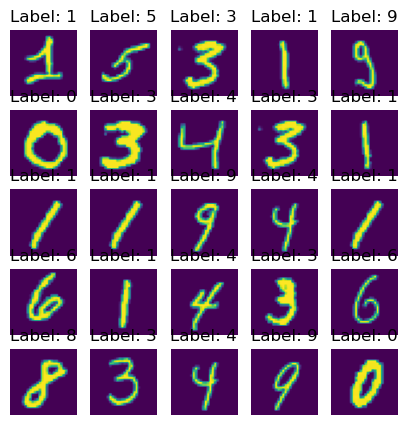

In [33]:
from numpy.random import randint
fig, axes = plt.subplots(5,5,figsize = (5,5))
axes = axes.flatten()
for ax, image_eg in enumerate(randint(0,64,size = 25)):
    axes[ax].set_title(f'Label: {label[image_eg]}')
    axes[ax].axis('off')
    #axes[ax].imshow((image[image_eg]/255).reshape((28,28)))
    axes[ax].imshow(image[image_eg].reshape((28,28)))


# Example data
plt.show()

Building a NN
-  input layer: 28x28 = 784 inputs(image size) (value 0-1, normalized)
-  hidden layer(s): hard to determine parameters, need to play around
    - how many layers ?
    - how many nodes ? - more than input layer?
- output layer: 10 outputs (digits 0-9) (value 0-1; the output with the highest value is the predicted label)
- weights between nodes of different layers (value 0-1; initiallize randomly)
- each node in hidden & output layers performs a weighed sum (or some other operation) on the node 'output' values and weights from previous layer
- an activation function and bias determines how this 'weighed sum' will be reflected in the 'output' of the current node

In [15]:
# fully connected (fc) block (will repeat for multiple hidden layers)
def fc_block(input_size:int,
            output_size:int,
            activation_function:object):
    return nn.Sequential(
        # how to perform "weighed sum" on 'output' of previous layer
        nn.Linear(input_size,output_size),
        # what to do with "weighed sum"
        activation_function())
    
# start with fully connected network
class My_First_NN (nn.Module):
    def __init__(self,
                 in_channels:int,
                 hidden_layers_sizes:list,
                 out_channels:int,
                activation:object):
        # initialize whatever is in __init__ of nn.Module
        super(My_First_NN, self).__init__()
        # this one way how input & hidden layers can be defined
        # sizes (number of nodes) of each layer
        layer_sizes = [in_channels,*hidden_layers_sizes]
        # make blocks of fully connected layers 
        fully_connected_blocks = [fc_block(in_n, out_n, activation)
                                  for in_n, out_n in zip(layer_sizes, layer_sizes[1:])]
        # these will be sequentially executed in the forward pass
        self.layers = nn.Sequential(*fully_connected_blocks,
                                    # for output layer only want weighed sum
                                    nn.Linear(layer_sizes[-1],out_channels))
        
    def forward(self, x):
        # flatten input
        x = x.view(x.size(0),-1)
        # forward pass of input through network
        x = self.layers(x)
        # at the end, x is a list of 10 numbers from 0-10 telling us
        # which label the model predicts
        return x

first_model = My_First_NN(784,
                          # completely arbitrary number of hidden layers & nodes
                          # tried [200,300,200] - better vs [20,30,20] - poor hidden layers; [500,250,50]
                         [20,30,20],
                         10,
                         nn.ReLU)
# inspect model architecture
print(first_model) # yes, as intended

My_First_NN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=20, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=20, out_features=30, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=30, out_features=20, bias=True)
      (1): ReLU()
    )
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)


Training:
- after one forward pass, get distribution of numbers in output layer which reflects "probability" that a given number is on the screen (highest output = highest probability that it is that label)
- we need to quantify how different the distribution is from the distribution that we want for the given label (0 prob for 9 digits not in picture and 1 prob for 1 digit on the picture) = Error
- calculate the gradient given the error
- update the weights according to the gradient (take a step down the gradient proportional to learning rate)

In [16]:
# training loop
def train_network (network:nn.Module,
                   data_loader:torch.utils.data.DataLoader,
                   epochs:int,
                   # these seem to be popular, beyond me why exactly
                   loss_function:nn.Module = nn.CrossEntropyLoss(),
                   # smaller so that model won't overfit
                   learning_rate:float = 0.001,
                   # here I found SDG and Adam as some popular options
                   optimizer:torch.optim.Optimizer = torch.optim.Adam):
    # set NN in training mode
    network.train(True)

    # set up optimizer
    optimizer = optimizer(network.parameters(), lr = learning_rate)
    # go through epochs
    for e,epoch in enumerate(range(epochs)):
        # load a batch of training data for given epoch
        for b,batch in enumerate(data_loader):
            samples, labels = batch[0], batch[1]
            # reset gradient, need to calculate gradient afresh every time
            optimizer.zero_grad()
            # run input data through network (somehow this works without calling forward methods)
            predictions = network(samples) #/255 MAYBE NOT normalize to 0-1 todo: find better place to do this
            # calculate eror
            error = loss_function(predictions, labels)
            # calculate gradient
            error.backward()
            # update weights by stepping down the gradient by learning rate sized step
            optimizer.step()
            print(e,b, 'done')

# let's train, see how long it takes
train_network(network=first_model,
             data_loader=dataloader,
             epochs = 10)# tried 5, 7 and 10 epochs; then tried 100 epochs to prevent overfitting

print("Training Finished")

NameError: name 'dataloader' is not defined

TESTING
evaluate performance ncorrect / nclassifications (for each digit & overall)

In [3]:
# testing loop
def test_performance (loader:torch.utils.data.DataLoader,
                      network:nn.Module,
                      print_which_correct:bool = False):
    # overall performance
    ncorrect, nclassification = 0,0

    # set model into testing mode
    network.eval()
    # context manager disables gradient calculation (only evaluation, doesn't change weights)
    with torch.no_grad():
        for images, labels in loader:
            outputs = network(images)
            # get the index at which the maximum probability occured (reduce over columns = dimension 1{dimension 0 is rows})
            predictions = torch.argmax(outputs,1)
            # makes a mask of True & False, summing over true gives number correct since True = 1
            ncorrect += sum(predictions == labels)
            nclassification += len(predictions)
            if print_which_correct == True:
                print(predictions == labels, labels)
                    
    performance = float(ncorrect)/float(nclassification)
    print(f'{ncorrect} / {nclassification} samples correct -> accuracy {performance*100:.2f} %')
    return performance
          
# test on training data
#training_data_performance = test_performance(dataloader,
 #                                            first_model)

In [17]:
# testing on testing (unseen data)
test_data_mnist = datasets.MNIST(root='.', # same directory
                                download=True, # if already downloaded won't do anything
                                transform = transform,
                                # testing part of dataset
                                train = False)

testloader = DataLoader(dataset = test_data_mnist, 
                        batch_size = 64,
                        num_workers = 4) # 4 cpu cores on my laptop

testing_performance = test_performance(loader = testloader,
                                     network = first_model)

9547 / 10000 samples correct -> accuracy 95.47 %


In [18]:
# save model with performance as part of name to current dir
# current dir
path = os.getcwd()
# file path
file_path = os.path.join(path, "models", f'fully_connected_{testing_performance}.pt')

# everything we want about a model (weights and biases obtained through training) model.in state_dict
torch.save(first_model.state_dict(), file_path)

print('model saved')

model saved


5 epochs: Not bad - performance on training and testing data almost the same ~ 67%

10 epochs: Quite a bit better - performance on training and testing data ~ 87 % 
Goal should be to get this performance higher tho, to >90 % (most easily improved by adding convolutional layers?)

changed model architecture from 300-200-300 hidden layer nodes to 200-300-200 and suddenly performance jumped to 98% 

USING HAND-DRAWN Digits

In [1]:
# use this to draw digits and label them
%run draw.py

pygame 2.2.0 (SDL 2.30.2, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


Found this information about MNIST dataset and some proposed ways to fix it:
"All images are size normalized to fit in a 20x20 pixel box and there are centered in a 28x28 image using the center of mass"
https://medium.com/@o.kroeger/tensorflow-mnist-and-your-own-handwritten-digits-4d1cd32bbab4

tried to implement to improve performance on own handdrawn digits; difference also in image processing library, using cv2 vs PIL, tried both 

torch.Size([61, 28, 28])
tensor(255.) tensor(0.)


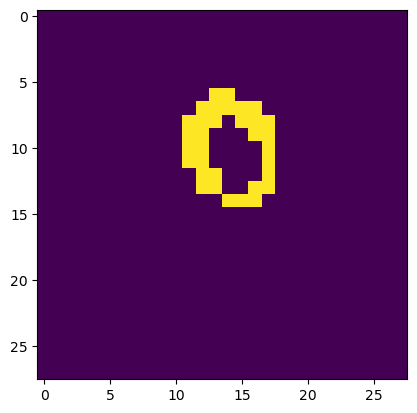

In [4]:
# for working with our images cv2 version
import cv2
from numpy import  vstack
#from numpy.linalg import inv
from torch.utils.data import Dataset

# filenames containing labels
my_testing_set = os.listdir('drawing')
# extract labels
labels = [int(x[0]) for x in my_testing_set]
# extract data
data = []

# transform data into tensor
for sample in my_testing_set:
    # get image & turn into greyscale (2d) array
    sample = cv2.imread(f'drawing/{sample}',
                        cv2.IMREAD_GRAYSCALE)
    
    # preprocessing steps
    # already array & inverted
    my_array = cv2.resize(255-sample,(28,28)).astype('int32') 
    data.append(
        my_array.reshape( 
            # shape for stacking
            (1,28,28)).astype('float32')) # back to float (like model)
    
# transform to tensor shape like training dataset before
data = torch.from_numpy(vstack(data))

print(data.shape)
print(data.max(),data.min())
plt.imshow(data[6,:,:])

torch.Size([61, 28, 28])
tensor(255.) tensor(0.)


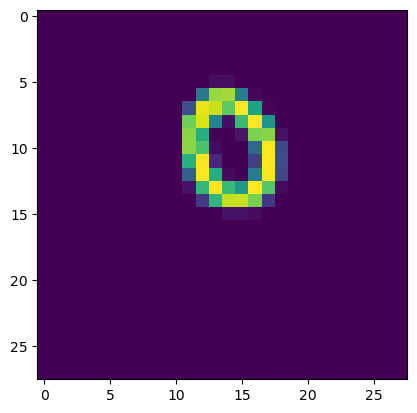

In [17]:
# for working with our images PIL version
from PIL import Image as img
from numpy import array, vstack, invert
#from numpy.linalg import inv
from torch.utils.data import Dataset

# filenames containing labels
my_testing_set = os.listdir('drawing')
# extract labels
labels = [int(x[0]) for x in my_testing_set]
# extract data
data = []

# transform data into tensor
for sample in my_testing_set:
    # get image
    sample = img.open(f'drawing/{sample}')
    
    # preprocessing steps
    sample = sample.resize((28,28))
    # turn into greyscale (2d) array, int for inversion operation
    my_array = array(sample.convert('L')).astype('int32')
    # invert colors (my drawings are black on white, MNIST are white on black)
    data.append(invert(
        my_array.reshape( # shape for stacking
            # MATCHING COLOR VALUES OF DATASET
            (1,28,28))-256).astype('float32')) # back to float (like model)

# transform to tensor shape like before
data = torch.from_numpy(vstack(data))

print(data.shape)
print(data.max(),data.min())
plt.imshow(data[6,:,:])

In [5]:
# class for our dataset format so that I can use it for DataLoader
class DrawDataset(Dataset):
    def __init__(self, data:torch.tensor, labels:list):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

Drawings = DrawDataset(data,
                       labels)

In [14]:
# LOADING SAVED MODELS WORKS!!!
my_loader = DataLoader(Drawings, 
                       batch_size = 4,
                       num_workers = 0)

# load pretrained model so don't have to train every time [change to only do this if the model is there in the directory
# and if so, use the one with highest accuracy (filename)
fc_model = My_First_NN(784,
                    # completely arbitrary number of hidden layers & nodes
                    #[200,300,200],#[20,30,20],[500,250,50]
                    # [20,30,20],
                    [500,250,50],
                    10,
                    nn.ReLU)

models = os.listdir('models')

# quick function to get model name either by name or by best model
def get_model_name_index (model_list:list,
                          by_name:bool|str = False):
    if by_name == False:
        return np.argmax([float(m.split('_')[-1].split('.pt')[0]) for m in model_list])
    else:
        return model_list.index(by_name)

# finds model with highest accuracy (always saved as last attribute
model_name = get_model_name_index(models,
                                  )# provide model name if to be loaded by name
print(f'Using model: {models[model_name]}')

load_dir = os.path.join(os.getcwd(),
                        'models',
                        models[model_name])
print(load_dir)

fc_model.load_state_dict(torch.load(load_dir))

# handdrawn data performance
print(type(fc_model))

hand_drawn_performance = test_performance(my_loader,
                                         fc_model,
                                         print_which_correct=True)

Using model: fully_connected_0.9794.pt
c:\Users\matus\OneDrive\Documents\university\Psychology 3rd year\Data Processing\pytorch_final_project\pytorch_final_project\models\fully_connected_0.9794.pt
<class '__main__.My_First_NN'>
tensor([False, False,  True,  True]) tensor([0, 0, 0, 0])
tensor([False, False, False, False]) tensor([0, 0, 0, 0])
tensor([False,  True,  True,  True]) tensor([0, 0, 1, 1])
tensor([ True,  True,  True, False]) tensor([1, 1, 1, 1])
tensor([False, False, False, False]) tensor([1, 1, 1, 1])
tensor([False,  True,  True,  True]) tensor([2, 2, 2, 2])
tensor([False, False, False, False]) tensor([2, 2, 3, 3])
tensor([ True, False, False, False]) tensor([3, 3, 3, 3])
tensor([ True,  True, False, False]) tensor([4, 4, 4, 4])
tensor([ True, False,  True, False]) tensor([4, 5, 5, 5])
tensor([False, False, False, False]) tensor([5, 5, 6, 6])
tensor([False, False, False, False]) tensor([6, 6, 7, 7])
tensor([ True,  True, False,  True]) tensor([7, 7, 7, 7])
tensor([ True, Fal

Performance on our own drawings is POOR (before inverting color it was 6%, now 10% still bad, getting somewhere around 20-23%; 
new architecture 26%; simple architecture and 10 epochs - 30%; using cv2 instead of PIL - 36%)

How to improve? 

Convolutional?